In [55]:
import zipfile
import pandas as pd
import os

with zipfile.ZipFile(os.path.join('tm10007_ml','ecg','ecg_data.zip'), 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 827
The number of columns: 9001


In [72]:
# General packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets as ds
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import roc_auc_score

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV, SelectKBest, SelectFdr, chi2, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve 
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from scipy.stats import zscore
import seaborn as sns

In [73]:
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = model_selection.train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)
print(X_test.shape)
print(X_train.shape)

(207, 9000)
(620, 9000)


In [ ]:
#Data gestandardization
#X_train = np.log(X_train)

c:\Users\marti\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


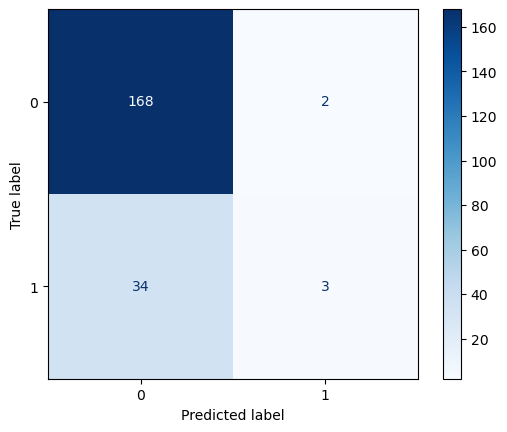

Accuracy:  0.826
Precision: 0.600
Recall:    0.081
F1 Score:  0.143
AUC Score: 0.614


In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Baseline model trainen, print roc_auc score 
knn= KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"AUC Score: {auc:.3f}")




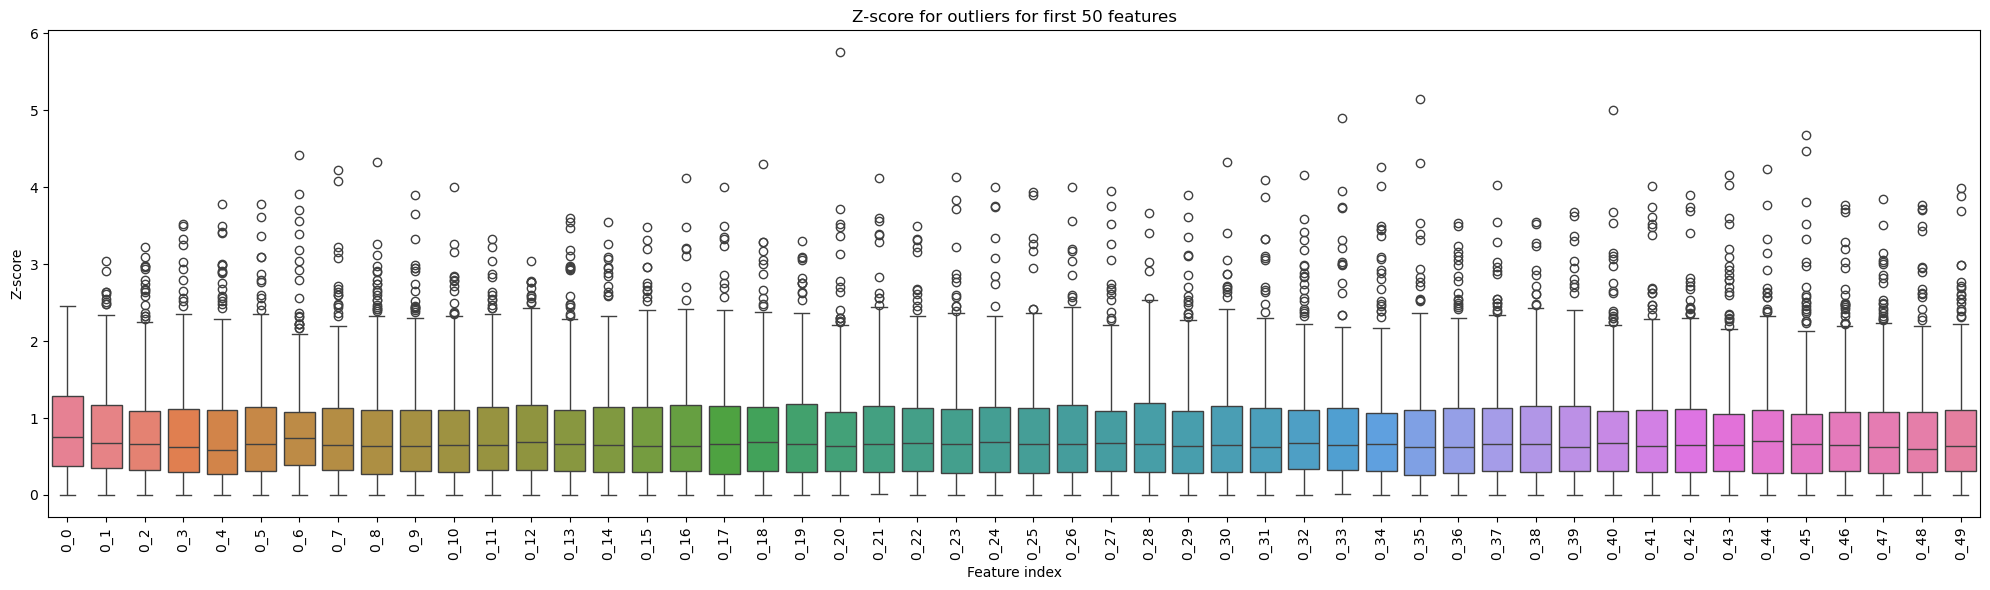

In [104]:
#Preprocessing: outliers plotten for first 50 features
X_subset = X_train.iloc[:, :50]
z_scores = np.abs(zscore(X_subset))

plt.figure(figsize=(20, 6))
sns.boxplot(data=pd.DataFrame(z_scores, columns=X_subset.columns))
plt.title("Z-score for outliers for first 50 features")
plt.xlabel("Feature index")
plt.ylabel("Z-score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
#plot learning curve

# # Load functions
# def plot_learning_curve(X_train, y_train, classifier, scoring, clf_type):
#     if scoring == 'error':
#         train_sizes, train_scores, test_scores = learning_curve(
#             classifier,
#             X_train,
#             y_train,
#             cv=StratifiedKFold(n_splits=5),
#             scoring='accuracy',
#             train_sizes=np.linspace(0.1, 1.0, 50),
#             n_jobs=-1
#         )
#         train_scores_mean = 1-np.mean(train_scores, axis=1)
#         train_scores_std = np.std(train_scores, axis=1)
#         test_scores_mean = 1-np.mean(test_scores, axis=1)
#         test_scores_std = np.std(test_scores, axis=1)
#     else:
#         train_sizes, train_scores, test_scores = learning_curve(
#             classifier,
#             X_train,
#             y_train,
#             cv=StratifiedKFold(n_splits=5),
#             scoring=scoring,
#             train_sizes=np.linspace(0.1, 1.0, 20),
#             n_jobs=-1
#         )
#         train_scores_mean = np.mean(train_scores, axis=1)
#         train_scores_std = np.std(train_scores, axis=1)
#         test_scores_mean = np.mean(test_scores, axis=1)
#         test_scores_std = np.std(test_scores, axis=1)

#     plt.figure(figsize=(10, 6))
#     plt.title(f"Learning Curve ({clf_type})")
#     plt.xlabel("Number of training objectes")
#     plt.ylabel(scoring)

#     plt.grid()

#     plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                     train_scores_mean + train_scores_std, alpha=0.1, color="blue")

#     plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="green")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                     test_scores_mean + test_scores_std, alpha=0.1, color="green")

#     plt.legend(loc="best")
#     plt.tight_layout()
#     plt.show()


c:\Users\marti\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
247 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
247 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marti\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marti\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\marti\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, r

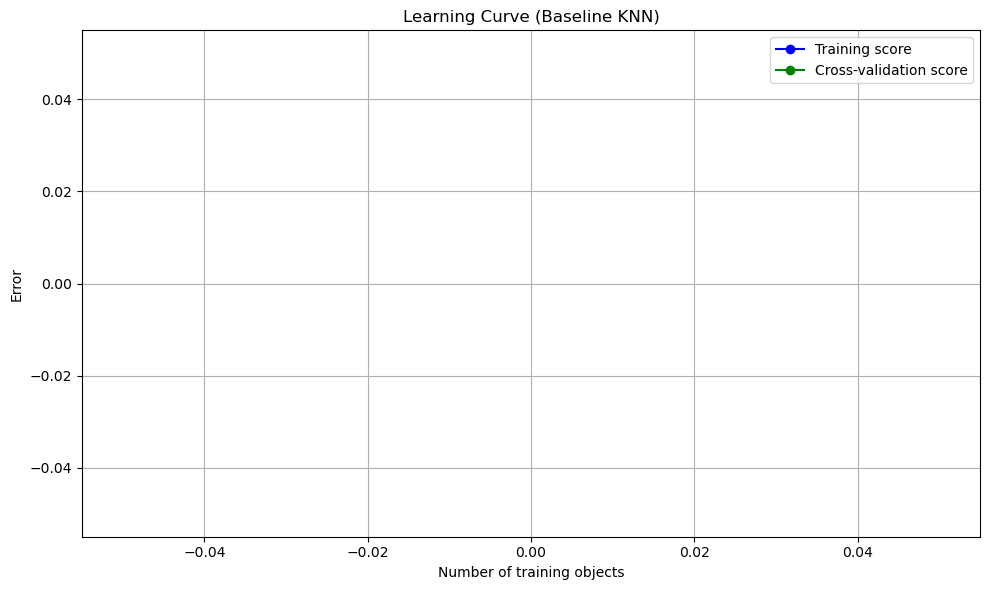

In [102]:
# Stel hier je inputs in:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif, k=400)),
    ('classifier', KNeighborsClassifier())
])

scoring = 'error'  
clf_type = 'Baseline KNN'
classifier = pipeline  

# Learning curve genereren
if scoring == 'error':
    train_sizes, train_scores, test_scores = learning_curve(
        classifier,
        X_train,
        y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 50),
        n_jobs=-1
    )
    train_scores_mean = 1 - np.mean(train_scores, axis=1)
    train_scores_std = np.std(1 - train_scores, axis=1)
    test_scores_mean = 1 - np.mean(test_scores, axis=1)
    test_scores_std = np.std(1 - test_scores, axis=1)
else:
    train_sizes, train_scores, test_scores = learning_curve(
        classifier,
        X_train,
        y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 20),
        n_jobs=-1
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

# Plotten
plt.figure(figsize=(10, 6))
plt.title(f"Learning Curve ({clf_type})")
plt.xlabel("Number of training objects")
plt.ylabel("Error" if scoring == 'error' else scoring)

plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="blue")

plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="green")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="green")

plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold

pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(mutual_info_classif, k=400)),
    ('classifier', KNeighborsClassifier())
])

pipeline.fit(X_train, y_train)

#plot_learning_curve(X_train, y_train, classifier=pipeline, scoring='error', clf_type='Baseline KNN, k=400')


KeyboardInterrupt: 

In [ ]:
#Hyperparameter selection, with feature selection k=800. 
knn = Pipeline([('scaler', RobustScaler()),('feature_selection', SelectKBest(mutual_info_classif, k=k)),('classifier', KNeighborsClassifier())])

parameters = {
    'feature_selection__k': np.arange(100, 9000, 300),
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],     
    } 

model = RandomizedSearchCV(
    estimator=knn,
    param_distributions=parameters,
    n_iter=10,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'  
)

model.fit(X_train, y_train)

print("Best estimator:", model.best_estimator_ )
print("Best Score:", model.best_score_)
print("best parameters:", model.best_params_)


Best estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selection',
                 SelectKBest(k=1300,
                             score_func=<function mutual_info_classif at 0x000001C15D24DA80>)),
                ('classifier',
                 KNeighborsClassifier(metric='chebyshev', n_neighbors=19,
                                      weights='distance'))])
Best Score: 0.7138971299022698
best parameters: {'feature_selection__k': 1300, 'classifier__weights': 'distance', 'classifier__n_neighbors': 19, 'classifier__metric': 'chebyshev'}


In [87]:
# In the code above is shown there are 5800 features selected. For the rest of the code we use these features
knn = Pipeline([('scaler', RobustScaler()),('feature_selection', SelectKBest(mutual_info_classif, k=800)),('classifier', KNeighborsClassifier())])

parameters = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],     
    } 

model = RandomizedSearchCV(
    estimator=knn,
    param_distributions=parameters,
    n_iter=10,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'  
)

model.fit(X_train, y_train)

print("Best estimator:", model.best_estimator_ )
print("Best Score:", model.best_score_)
print("best parameters:", model.best_params_)


Best estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selection',
                 SelectKBest(k=800,
                             score_func=<function mutual_info_classif at 0x000001C15D24DA80>)),
                ('classifier',
                 KNeighborsClassifier(metric='chebyshev', n_neighbors=21))])
Best Score: 0.7267114524538854
best parameters: {'classifier__weights': 'uniform', 'classifier__n_neighbors': 21, 'classifier__metric': 'chebyshev'}


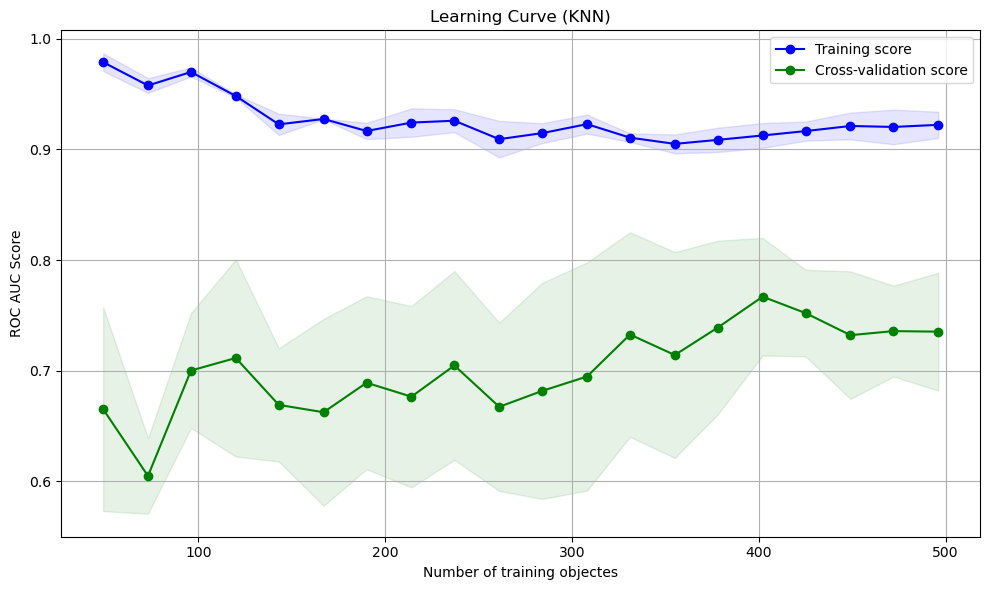

In [ ]:
#Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model.best_estimator_,
    X_train,
    y_train,
    cv=5,
    scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 20),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve (KNN)")
plt.xlabel("Number of training objectes")
plt.ylabel("ROC AUC Score")

plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="blue")

plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="green")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="green")

plt.legend(loc="best")
plt.tight_layout()
plt.show()